The purpose of this script is to compare analytical and simulated results for Gamma distributions, i.e. a chain with irreversible steps of fixed rate.

Last updated by: Jonathan Liu, 10/14/2020

In [1]:
#Import necessary packages
#matplotlib inline
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import scipy.special as sps

For a process with n irreversible steps with the same, constant transition rate k, the distribution of waiting times to finish the last step is Gamma-distributed, with mean n/k and variance n/k^2.

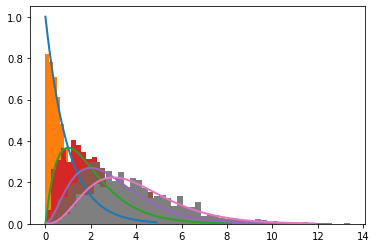

In [2]:
#Function for analytical Gamma distribution
def GamPDF(x,shape,rate):
    return x**(shape-1)*(np.exp(-bins*rate) / sps.gamma(shape)*(1/rate)**shape)
    
#First, let's plot the full distributions for increasing numbers of steps.
k = 1
nums = range(4)
n_samples = 1000 #Number of random samples
gamSamples = []

for i in nums:
    gamSamples.append(np.random.default_rng().gamma(i+1,1/k,n_samples))

#Plot the results
bins = np.arange(0,5,0.1)
for i in nums:
    plt.plot(bins, GamPDF(bins,nums[i]+1,k), linewidth=2)  
    count, bins, ignored = plt.hist(gamSamples[i], 50, density=True)
plt.show()

In [3]:
#Simulation for calculating onset times

def CalculatetOn_NEqualTransitions(time,dt,w,N_trans,N_cells):
#Calculates the onset time for a model with N irreversible transitions of
#equal magnitude. The transition rate can be time-varying, but is the same
#global rate for each transition. The model assumes N+1 states, beginning
#in the 0th state. Using finite timesteps and a Markov chain formalism, it
#simulates N realizations of the overall time it takes to reach the
#(N+1)th state. This is vectorized so it calculates it for all AP
#positions.

#Last updated by Jonathan Liu, 3/30/2020

# Inputs:
#   time: simulation time vector
#   dt: simulation timestep
#   w: transition probability vector at each timepoint
#   N_trans: number of irreversible transitions
#   N_cells: number of cells to simulate

# Outputs:
#   t_on: time to reach the final state for each cell (length = N_cells)

## Setup variables
    t_on = np.empty(N_cells) #Time to transition to final ON state for each cell
    t_on[:] = np.nan
    state = np.zeros(N_cells) #State vector describing current state of each cell
    finished_states = np.zeros(N_cells) #Vector storing finished statuses of each cell

    ## Run simulation
    #Loop over time
    #q = waitbar(0,'Running simulation...')
    for i in range(len(time)):
        if np.sum(finished_states) == N_cells: #If all cells have turned on, stop the simulation
            #print('Halting simulation since all cells have turned on.')
            break
        #Simulate binomial random variable to see if each cell has transitioned
        #If the input transition rate is a nan, this will manifest as never
        #transitioning.
        p = w[i] * dt #Probability of transition at this timestep
        transitioned = np.random.binomial(1,p,N_cells) #Binary transition decision for each cell

        #Advance the cells that did transition to the next state
        states_to_advance = transitioned == 1
        state[transitioned == 1] = state[transitioned == 1] + 1

        #See if any states have reached the ON state
        t_on[state == N_trans] = time[i]
        finished_states[state == N_trans] = 1
        state[state == N_trans] = np.nan #Move finished states out of consideration

        #waitbar(i/length(time),q,'Running simulation...')
    return t_on

P:\Jonathan\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
P:\Jonathan\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


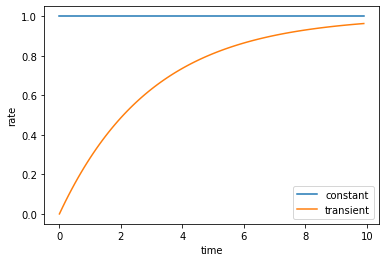

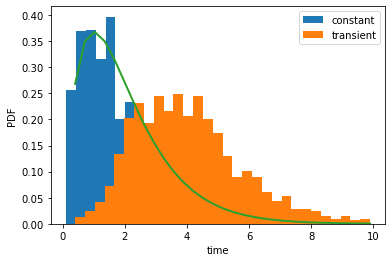

In [4]:
#Testing the simulation script
#First, with constant rate
time = np.arange(0,10,0.1)
dt = 0.1
w_base = 1
w_const = w_base * np.ones(time.shape)
N_trans = 2
N_cells = 1000

#Now with transient exponential rate
tau = 3
w_trans = w_base * (1 - np.exp(-time / tau))

t_on_const = CalculatetOn_NEqualTransitions(time,dt,w_const,N_trans,N_cells)
t_on_trans = CalculatetOn_NEqualTransitions(time,dt,w_trans,N_trans,N_cells)

#Plot the inputs
plt.figure()
plt.plot(time,w_const,label='constant')
plt.plot(time,w_trans,label='transient')
plt.xlabel('time')
plt.ylabel('rate')
plt.legend()

#Plot the distributions
plt.figure()
count, bins, ignored = plt.hist(t_on_const, 30,density=True, label='constant')
count, bins, ignored = plt.hist(t_on_trans, 30,density=True, label='transient')
plt.plot(bins, GamPDF(bins,N_trans,w_base), linewidth=2)  
plt.xlabel('time')
plt.ylabel('PDF')
plt.legend()

Text(0, 0.5, 'variance')

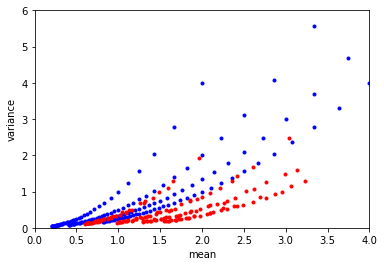

In [5]:
#Plot the mean and variance of the Gamma distribution in 2D parameter space, for a given set of parameters
#Function returning the mean and variance of a Gamma distribution
def MeanVarGamDist(shape,rate):
    return shape/rate, shape/rate**2

#Let's create a grid of shape and rate parameters
n_steps = np.arange(1,5)
rate = np.arange(0.5,5,0.1)
means_const = np.zeros((len(n_steps),len(rate)))
variances_const = np.zeros((len(n_steps),len(rate)))

for i in range(len(n_steps)):
    for j in range(len(rate)):
        means_const[i,j], variances_const[i,j] = MeanVarGamDist(n_steps[i],rate[j])

#Now using the transient simulation
time = np.arange(0,10,0.1)
dt = 0.1
N_trans = 2
N_cells = 1000
tau = 1

means_trans = np.zeros((len(n_steps),len(rate)))
variances_trans = np.zeros((len(n_steps),len(rate)))
for i in range(len(n_steps)):
    for j in range(len(rate)):
        w_trans = rate[j] * (1 - np.exp(-time / tau))
        t_on_trans = CalculatetOn_NEqualTransitions(time,dt,w_trans,n_steps[i],N_cells)
        means_trans[i,j] = np.mean(t_on_trans)
        variances_trans[i,j] = np.var(t_on_trans)
        

    
plt.figure()
plt.plot(means_const,variances_const, 'b.')
plt.plot(means_trans,variances_trans, 'r.')
plt.xlim(0,4)
plt.ylim(0,6)
plt.xlabel('mean')
plt.ylabel('variance')
plt.title('Parameter space')

Nice! If we look at a vertical slice of constant mean, it looks like the transient input can achieve lower variances than the constant input

(1, 150)
(1, 150)


(0.0, 5.0)

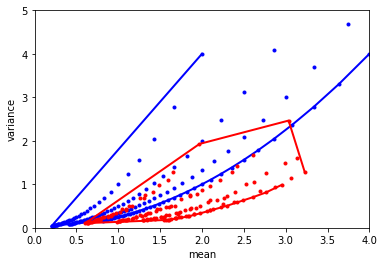

In [6]:
#Plotting the boundary
#Reshape the mean and variance arrays
means_const_flat = np.reshape(means_const,(1,means_const.shape[0]*means_const.shape[1]))
variances_const_flat = np.reshape(variances_const,(1,variances_const.shape[0]*variances_const.shape[1]))

#Remove nans
means_trans = means_trans[~np.isnan(means_trans)]
variances_trans = variances_trans[~np.isnan(variances_trans)]

means_trans_flat = np.reshape(means_trans,(1,means_trans.shape[0]))
variances_trans_flat = np.reshape(variances_trans,(1,variances_trans.shape[0]))

print(means_trans_flat.shape)
print(variances_trans_flat.shape)

#Convex hulls
points_const = np.concatenate((means_const_flat,variances_const_flat),axis=0)
points_const = np.transpose(points_const) #Transpose dimensions for convex hull to work
hull_const = ConvexHull(points_const)

points_trans = np.concatenate((means_trans_flat,variances_trans_flat),axis=0)
points_trans = np.transpose(points_trans) #Transpose dimensions for convex hull to work
hull_trans = ConvexHull(points_trans)

#Plot boundary
plt.figure()
plt.plot(means_const_flat,variances_const_flat,'b.', label='constant') #Constant model
plt.plot(points_const[hull_const.vertices,0], points_const[hull_const.vertices,1], 'b-', lw=2) #Convex hull
plt.plot(means_trans_flat,variances_trans_flat,'r.', label='transient') #Transient model
plt.plot(points_trans[hull_trans.vertices,0], points_trans[hull_trans.vertices,1], 'r-', lw=2) #Convex hull
plt.xlabel('mean')
plt.ylabel('variance')
plt.xlim(0, 4)
plt.ylim(0, 5)
plt.title('Parameter space with boundaries')

Now let's look at what happens to the variance for fixed step number $n=3$ as we change the transition rate, and compare the steady state case with transient cases of varying time constant $\tau$.

Text(0.5, 1.0, 'n = 3steps, varying rate')

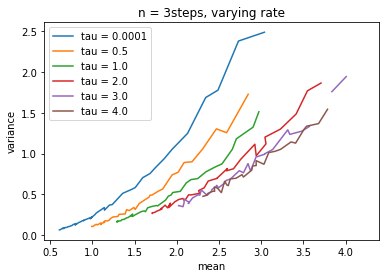

In [23]:
#Model parameters
n_steps = 3
rate = np.arange(0.5,5,0.1)
tau = np.array([0.0001,0.5,1,2,3,4])
means = np.zeros((len(tau),len(rate)))
variances = np.zeros((len(tau),len(rate)))

#Simulation parameters
time = np.arange(0,10,0.1)
dt = 0.1
N_trans = 2
N_cells = 1000


for i in range(len(tau)):
    for j in range(len(rate)):
        w_trans = rate[j] * (1 - np.exp(-time / tau[i]))
        t_on_trans = CalculatetOn_NEqualTransitions(time,dt,w_trans,n_steps,N_cells)
        means[i,j] = np.mean(t_on_trans)
        variances[i,j] = np.var(t_on_trans)
        
#Plot results
plt.figure()
for i in range(len(tau)):
    plt.plot(means[i,:],variances[i,:],label='tau = ' + str(tau[i]))
    
plt.legend()
plt.xlabel('mean')
plt.ylabel('variance')
plt.title('n = ' + str(n_steps) + ' steps, varying rate')

array([1.e-04, 2.e+00, 3.e+00, 4.e+00])